Loading tokenizer...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading model...


/root/anaconda3/envs/caption/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/root/anaconda3/envs/caption/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Model loaded successfully!
Total frames in video: 300, FPS: 29, Extracting 8 frames...


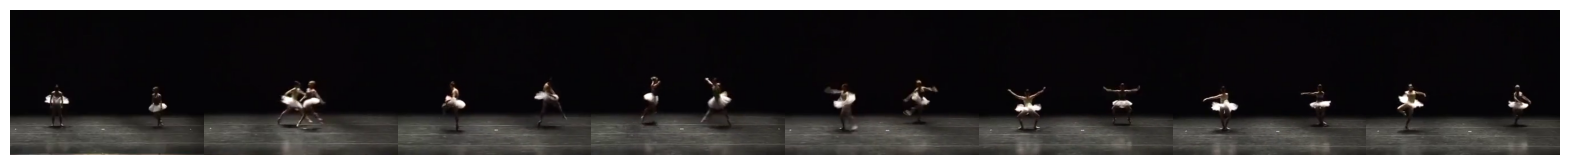

Captions for the extracted frames:


: 

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoTokenizer, AutoModelForCausalLM
import cv2
from IPython.display import display, HTML

# 设置为离线模式
os.environ["TRANSFORMERS_OFFLINE"] = "1"

# 模型和设备配置
MODEL_PATH = "/opt/data/private/hhc/workdir/CogVLM2/model"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TORCH_TYPE = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float16

# 加载模型和分词器
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, trust_remote_code=True)

print("Loading model...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=TORCH_TYPE,
    trust_remote_code=True,
    low_cpu_mem_usage=True
).eval()
print("Model loaded successfully!")

# 输入视频路径
video_path = "/opt/data/private/hhc/workdir/CogVLM2/haichen/ballet.mp4"  # 替换为你的视频路径
T = 8  # 需要抽取的帧数

# 读取视频并抽取帧
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_interval = max(total_frames // T, 1)  # 根据视频总帧数和T计算帧间隔

captions = []  # 用于存储每帧的描述
frames = []  # 存储处理后的帧

print(f"Total frames in video: {total_frames}, FPS: {fps}, Extracting {T} frames...")

frame_count = 0
selected_frames = 0

while cap.isOpened() and selected_frames < T:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % frame_interval == 0:  # 按间隔抽取帧
        # 将帧从 BGR 转为 RGB，并转为 PIL 格式
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        # 存储帧
        frames.append(image)

        # 构造输入
        query = "Describe this image in one sentence. Prioritize accuracy. Start with 'The image shows'"
        history = []
        input_by_model = model.build_conversation_input_ids(
            tokenizer,
            query=query,
            history=history,
            images=[image],
            template_version='chat'
        )

        inputs = {
            'input_ids': input_by_model['input_ids'].unsqueeze(0).to(DEVICE),
            'token_type_ids': input_by_model['token_type_ids'].unsqueeze(0).to(DEVICE),
            'attention_mask': input_by_model['attention_mask'].unsqueeze(0).to(DEVICE),
            'images': [[input_by_model['images'][0].to(DEVICE).to(TORCH_TYPE)]]
        }

        gen_kwargs = {
            "max_new_tokens": 800,
            "pad_token_id": 128002,
        }

        # 使用模型生成描述
        with torch.no_grad():
            outputs = model.generate(**inputs, **gen_kwargs)
            outputs = outputs[:, inputs['input_ids'].shape[1]:]
            response = tokenizer.decode(outputs[0])
            response = response.split("<|end_of_text|>")[0]
            # print(f"Caption for frame {frame_count}: {response}")

        # 将结果存入列表
        captions.append(response)
        selected_frames += 1

    frame_count += 1

# 释放视频对象
cap.release()

# 网格化展示帧
num_cols = 8  # 每行展示的帧数
fig, axes = plt.subplots(1, num_cols, figsize=(20, 5))  # 创建一行多个子图

# 设置子图间隔为0
plt.subplots_adjust(wspace=0, hspace=0)

for i, ax in enumerate(axes.flat):
    if i < len(frames):
        # 显示帧
        ax.imshow(frames[i])
        ax.axis("off")  # 关闭坐标轴
    else:
        ax.axis("off")  # 如果没有帧，关闭此子图

plt.show()

# 添加描述到 HTML 格式输出
print("Captions for the extracted frames:")
html_content = """
<div style='max-width: 100%; margin: 0 auto; text-align: left; font-family: Arial, sans-serif;'>
    <pre style='font-size: 16px; color: #333; background-color: #f9f9f9; padding: 10px; border: 1px solid #ccc; border-radius: 5px; white-space: pre-wrap; word-wrap: break-word;'>
"""

for i, caption in enumerate(captions):
    html_content += f"Frame {i + 1}: {caption}\n"

html_content += "</pre></div>"

# 使用 IPython.display 输出 HTML 格式化的文本
display(HTML(html_content))

